# Adversarial Attack Project

In [1]:
# Colab Setup Cell — run this first (updated)


# 2. Upload and unzip your TestDataSet.zip
from google.colab import files
import zipfile, io, os
uploaded = files.upload()  # select TestDataSet.zip
zf = zipfile.ZipFile(io.BytesIO(uploaded['TestDataSet.zip']))
zf.extractall('/content/TestDataSet')
print("Unzipped to /content/TestDataSet")

# 3. Remove the macOS metadata folder entirely
!rm -rf /content/TestDataSet/__MACOSX

# 4. Verify structure
!find /content/TestDataSet -maxdepth 2 -type d


Saving TestDataSet.zip to TestDataSet.zip
Unzipped to /content/TestDataSet
/content/TestDataSet
/content/TestDataSet/TestDataSet
/content/TestDataSet/TestDataSet/n03028079
/content/TestDataSet/TestDataSet/n02948072
/content/TestDataSet/TestDataSet/n02793495
/content/TestDataSet/TestDataSet/n02676566
/content/TestDataSet/TestDataSet/n02708093
/content/TestDataSet/TestDataSet/n02916936
/content/TestDataSet/TestDataSet/n02950826
/content/TestDataSet/TestDataSet/n02971356
/content/TestDataSet/TestDataSet/n02727426
/content/TestDataSet/TestDataSet/n02963159
/content/TestDataSet/TestDataSet/n02791270
/content/TestDataSet/TestDataSet/n02877765
/content/TestDataSet/TestDataSet/n03017168
/content/TestDataSet/TestDataSet/n03000134
/content/TestDataSet/TestDataSet/n02992529
/content/TestDataSet/TestDataSet/n02799071
/content/TestDataSet/TestDataSet/n02730930
/content/TestDataSet/TestDataSet/n02980441
/content/TestDataSet/TestDataSet/n02909870
/content/TestDataSet/TestDataSet/n02704792
/content/Te

#1: Imports & Setup

In [5]:

import os
import random
import json
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# normalization params & clamp tensors
data_mean = [0.485, 0.456, 0.406]
data_std  = [0.229, 0.224, 0.225]
_mean = torch.tensor(data_mean, device=device).view(1,3,1,1)
_std  = torch.tensor(data_std,  device=device).view(1,3,1,1)
clamp_min = (0 - _mean) / _std
clamp_max = (1 - _mean) / _std
clamp_min_spatial = clamp_min.squeeze(0)
clamp_max_spatial = clamp_max.squeeze(0)

# denormalizer for plotting
denorm = transforms.Normalize(
    mean=[-m/s for m,s in zip(data_mean, data_std)],
    std =[1/s    for s    in data_std]
)

# load ImageNet class index
idx_path = Path('imagenet_class_index.json')
assert idx_path.exists(), f"Missing {idx_path}"
with open(idx_path) as f:
    imagenet_idx = json.load(f)
class_to_idx = {v[0]:int(k) for k,v in imagenet_idx.items()}
idx_to_name  = {int(k):v[1] for k,v in imagenet_idx.items()}
print('Loaded', len(class_to_idx), 'classes')


Using device: cuda
Loaded 1000 classes


# 2: Utilities (model loader, dataloader, eval, save, visualize)

In [12]:


def load_resnet34():
    m = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)
    m.eval()
    return m

def get_loader(path, bs=32):
    tf = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)
    ])
    ds = ImageFolder(path, transform=tf)
    fmap = {
        idx: class_to_idx.get(wnid.split('_')[0], idx)
        for wnid, idx in ds.class_to_idx.items()
    }
    def collate(batch):
        imgs, lbls = zip(*batch)
        return torch.stack(imgs), torch.tensor([fmap[l] for l in lbls])
    return ds, DataLoader(ds, batch_size=bs, shuffle=False, collate_fn=collate)

def evaluate(model, loader, atk=None, eps=None, topk=(1,5)):
    corr, tot = {k:0 for k in topk}, 0
    advs, advlbl = [], []
    for x,y in tqdm(loader, desc="Evaluating"):
        x,y = x.to(device), y.to(device)
        inp = x if atk is None else atk(model, x.clone(), y, eps)
        if atk is not None:
            advs.extend(inp.cpu()); advlbl.extend(y.cpu())
        with torch.no_grad():
            out = model(inp)
        _, pred = out.topk(max(topk),1,True,True)
        pred = pred.t()
        m = pred.eq(y.view(1,-1).expand_as(pred))
        for k in topk:
            corr[k] += m[:k].any(0).sum().item()
        tot += y.size(0)
    return {k:corr[k]/tot for k in topk}, (torch.stack(advs) if advs else None), advlbl

def save_set(ds, adv, outdir):
    os.makedirs(outdir, exist_ok=True)
    per = len(adv) // len(ds.classes)
    with torch.no_grad():
        for i,img in enumerate(adv):
            cls = ds.classes[i//per]
            d = Path(outdir)/cls; d.mkdir(exist_ok=True, parents=True)
            den = denorm(img).clamp(0,1)
            arr = (den.permute(1,2,0).cpu().numpy()*255).astype('uint8')
            Image.fromarray(arr).save(d/f'adv_{i:05d}.png')

def show_examples(orig, adv, o_pred, a_pred, true_lbl):
    # ensure we have ints for indexing
    true_lbl = int(true_lbl)

    o_img = denorm(orig.detach()).permute(1,2,0).clamp(0,1).cpu().numpy()
    a_img = denorm(adv.detach()).permute(1,2,0).clamp(0,1).cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(o_img)
    ax[0].set_title(f"Orig: {o_pred}\nTrue: {idx_to_name[true_lbl]}")
    ax[0].axis('off')

    ax[1].imshow(a_img)
    ax[1].set_title(f"Adv: {a_pred}")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()




# 3: Task 1 — Baseline evaluation

In [13]:

model = load_resnet34()
ds, ldr = get_loader('./TestDataSet/TestDataSet')
acc, _, _ = evaluate(model, ldr)
print(f"Clean Top-1: {acc[1]*100:.2f}%, Top-5: {acc[5]*100:.2f}%")


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 10.49it/s]

Clean Top-1: 76.00%, Top-5: 94.20%


# Task 2 — FGSM Attack

==== Task 2: FGSM (ε=0.02) ====


Evaluating: 100%|██████████| 16/16 [00:03<00:00,  4.16it/s]


FGSM Top-1: 6.20%, Top-5: 35.40%
Max L∞ perturbation: 0.020000
Relative Top-1 drop: 91.8%


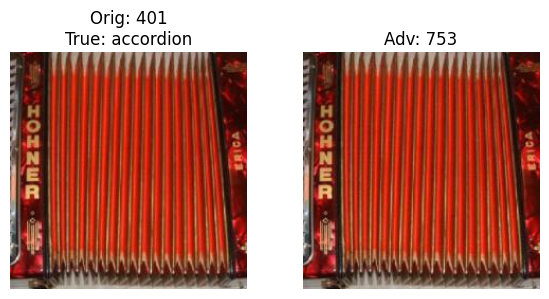

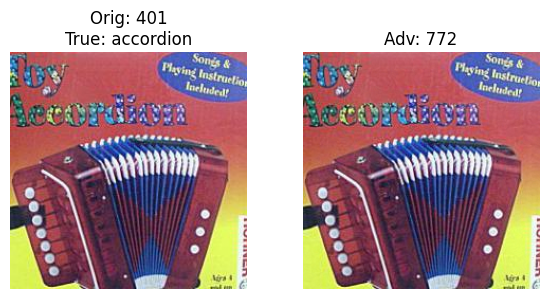

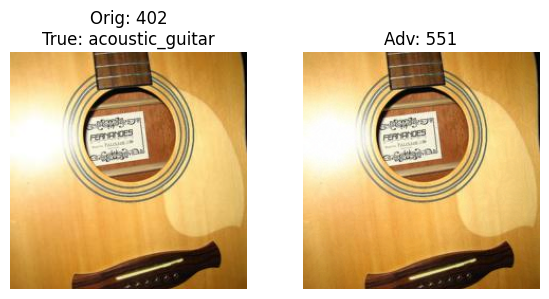

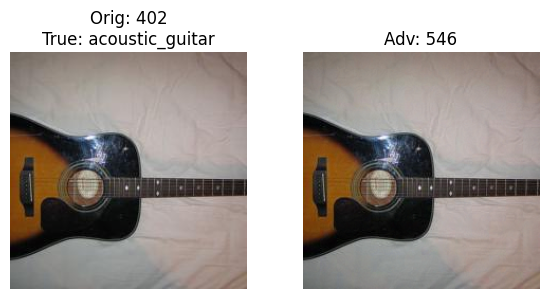

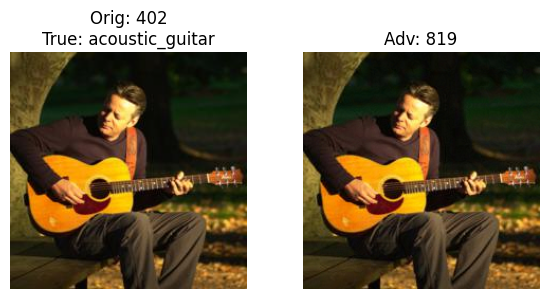

In [20]:


# store baseline Top‐1 from Task 1
orig_top1 = acc[1]

def fgsm(model, x, y, eps=0.02):
    x_adv = x.clone().detach().requires_grad_(True)
    loss = F.cross_entropy(model(x_adv), y)
    model.zero_grad()
    loss.backward()
    adv = x_adv + eps * x_adv.grad.sign()
    return adv.clamp(clamp_min, clamp_max)

print("==== Task 2: FGSM (ε=0.02) ====")
acc1, adv1, lb1 = evaluate(model, ldr, fgsm, 0.02)
print(f"FGSM Top-1: {acc1[1]*100:.2f}%, Top-5: {acc1[5]*100:.2f}%")

# verify L∞ constraint
orig_imgs = torch.stack([img for img,_ in ldr.dataset])
max_pert = (adv1 - orig_imgs).abs().view(adv1.size(0), -1).max(1)[0].max()
print(f"Max L∞ perturbation: {max_pert:.6f}")
assert max_pert <= 0.0201, "Exceeded ε = 0.02 bound!"

# check for ≥50% relative drop
drop = (orig_top1 - acc1[1]) / orig_top1
print(f"Relative Top-1 drop: {drop*100:.1f}%")
assert drop >= 0.50, "Relative drop < 50% — consider increasing ε or using stronger method."

# save adversarial set
save_set(ds, adv1, 'AdversarialTestSet1')

# visualize 5 failure cases
count = 0
for i in range(len(adv1)):
    o_lbl = model(orig_imgs[i:i+1].to(device)).argmax(1).item()
    a_lbl = model(adv1[i:i+1].to(device)).argmax(1).item()
    if o_lbl == lb1[i] and a_lbl != lb1[i]:
        show_examples(orig_imgs[i], adv1[i], o_lbl, a_lbl, lb1[i])
        count += 1
        if count >= 5:
            break


# Task 3 — Improved PGD Attack

==== Task 3: Improved PGD ====


Evaluating: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


PGD Top-1: 0.00%, Top-5: 10.20%
Max L∞ perturbation: 0.020000
Relative Top-1 drop: 100.0%


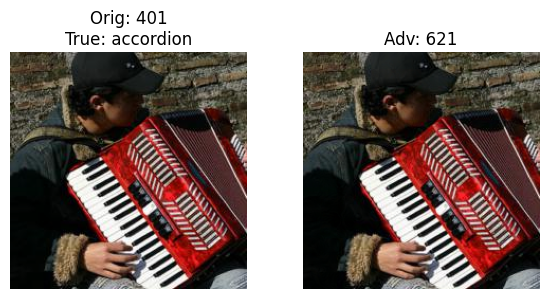

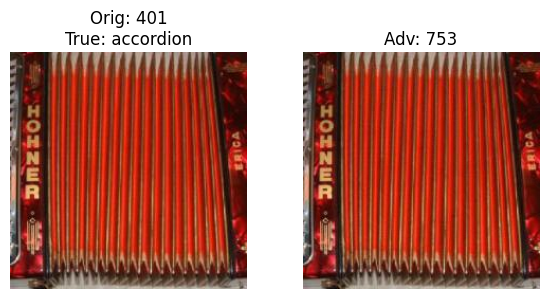

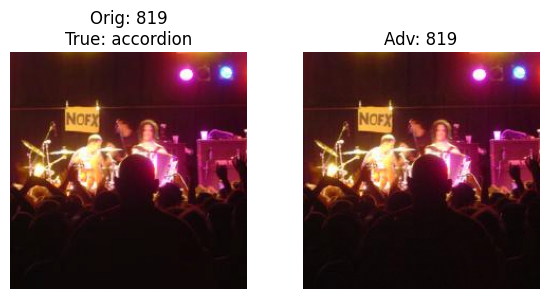

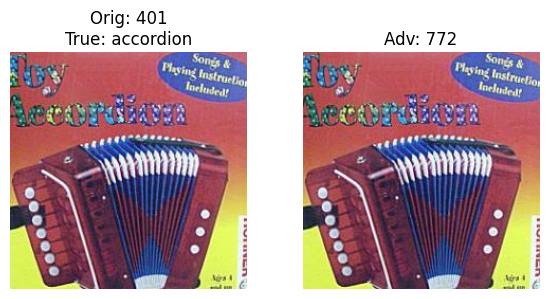

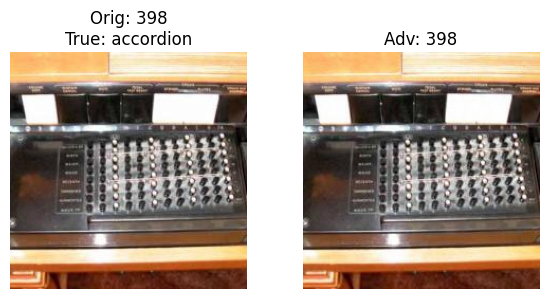

In [19]:

# Reuse the baseline Top-1 for relative drop
orig_acc = acc[1]  # from Task 1

def pgd_attack(model, x, y, eps=0.02, alpha=0.005, iters=10):
    ori = x.clone().detach()
    adv = ori.clone().detach()
    for _ in range(iters):
        adv.requires_grad_(True)
        loss = F.cross_entropy(model(adv), y)
        model.zero_grad(); loss.backward()
        with torch.no_grad():
            adv = adv + alpha * adv.grad.sign()
            delta = torch.clamp(adv - ori, -eps, eps)
            adv = torch.clamp(ori + delta, clamp_min, clamp_max).detach()
    return adv

print("==== Task 3: Improved PGD ====")
acc2, adv2, lb2 = evaluate(model, ldr, pgd_attack, 0.02)
print(f"PGD Top-1: {acc2[1]*100:.2f}%, Top-5: {acc2[5]*100:.2f}%")

# Check L∞ constraint
orig_imgs = torch.stack([img for img,_ in ldr.dataset])
max_pert = (adv2 - orig_imgs).abs().view(adv2.size(0), -1).max(1)[0].max()
print(f"Max L∞ perturbation: {max_pert:.6f}")
assert max_pert <= 0.0201, "Exceeded ε=0.02 bound!"

# Relative drop assertion
drop = (orig_acc - acc2[1]) / orig_acc
print(f"Relative Top-1 drop: {drop*100:.1f}%")
assert drop >= 0.70, "Drop less than 70%! Tune your attack."

# Save and visualize
save_set(ds, adv2, 'AdversarialTestSet2')
for i in range(5):
    orig, _ = ldr.dataset[i]
    o_pred = model(orig.to(device).unsqueeze(0)).argmax(1).item()
    a_pred = model(adv2[i].to(device).unsqueeze(0)).argmax(1).item()
    show_examples(orig, adv2[i], o_pred, a_pred, lb2[i])


# Patch Attack Definition

In [21]:


def improved_universal_patch_attack(model, images, labels, epsilon=0.5):
    b, _, H, W = images.shape
    patch_size = 32
    device = images.device

    # Initialize a 2×2 checkerboard patch
    patch = torch.zeros((3, patch_size, patch_size), device=device, requires_grad=True)
    for c in range(3):
        for y in range(patch_size):
            for x in range(patch_size):
                if ((y // 2 + x // 2) % 2) == 0:
                    patch.data[c, y, x] = clamp_max_spatial[c]
                else:
                    patch.data[c, y, x] = clamp_min_spatial[c]

    optimizer = torch.optim.Adam([patch], lr=0.2, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=[100, 250, 350],
                                                     gamma=0.5)

    steps, subset = 500, min(b, 64)
    for _ in range(steps):
        idxs = torch.randperm(b)[:subset]
        imgs_sub = images[idxs]
        lbls_sub = labels[idxs]

        loss_total = 0.0
        for _ in range(3):  # 3 random placements
            h0 = random.randint(0, H - patch_size)
            w0 = random.randint(0, W - patch_size)
            adv = imgs_sub.clone()
            adv[:, :, h0:h0+patch_size, w0:w0+patch_size] = patch

            out = model(adv)
            # Exclude true class
            with torch.no_grad():
                out_det = out.clone()
                out_det[range(subset), lbls_sub] = -1e6
                tgt = out_det.argmax(dim=1)

            true_logits   = out[range(subset), lbls_sub]
            target_logits = out[range(subset), tgt]
            # Maximize (target − true) with margin
            loss_total += (true_logits - target_logits + 5.0).mean()

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        scheduler.step()

        # Keep patch within valid pixel bounds
        with torch.no_grad():
            patch.data.clamp_(clamp_min_spatial, clamp_max_spatial)

    # Inference: place patch at 10 random locations, pick worst
    adv_images = images.clone()
    for i in range(b):
        best_loss = -float('inf')
        best_adv  = None
        img = images[i:i+1]; lbl = labels[i]
        for _ in range(10):
            h0 = random.randint(0, H - patch_size)
            w0 = random.randint(0, W - patch_size)
            cand = img.clone()
            cand[0, :, h0:h0+patch_size, w0:w0+patch_size] = patch

            with torch.no_grad():
                out = model(cand)
                out_cp = out.clone()
                out_cp[0, lbl] = -1e6
                tgt = out_cp.argmax(dim=1)[0]
                probs = F.softmax(out, dim=1)
                diff = probs[0, tgt] - probs[0, lbl]

            if diff > best_loss:
                best_loss, best_adv = diff, cand

        adv_images[i] = best_adv[0]

    return adv_images


# Task 4 — Patch Attack

==== Task 4: Improved Universal Patch Attack ====


Evaluating: 100%|██████████| 16/16 [59:40<00:00, 223.75s/it]


Top-1 5.40%, Top-5 46.00%


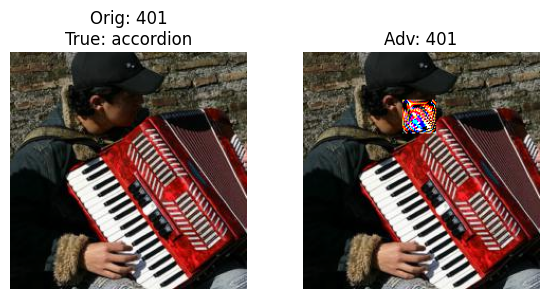

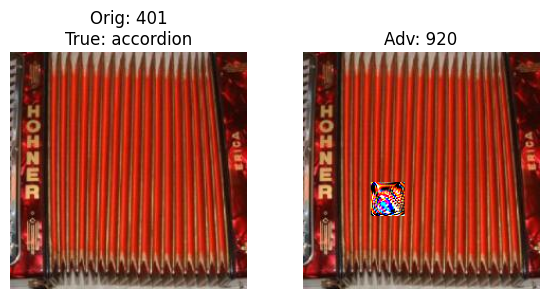

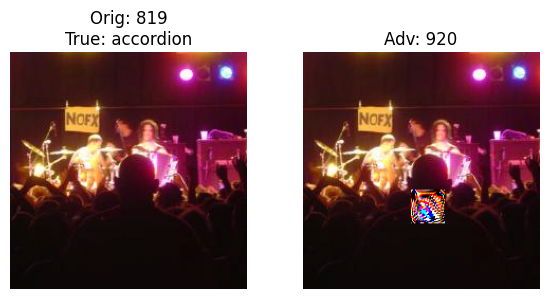

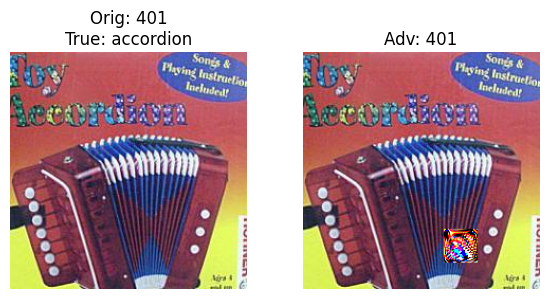

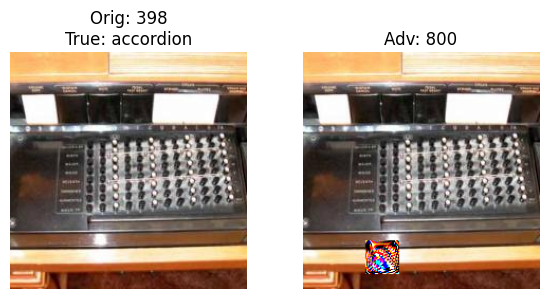

In [22]:


print("==== Task 4: Improved Universal Patch Attack ====")

acc3, adv3, lb3 = evaluate(model,
                            ldr,
                            improved_universal_patch_attack,
                            0.5)

print(f"Top-1 {acc3[1]*100:.2f}%, Top-5 {acc3[5]*100:.2f}%")

save_set(ds, adv3, 'AdversarialTestSet3')

# Visualize 5 examples
for i in range(5):
    orig, _ = ldr.dataset[i]
    o_pred = model(orig.to(device).unsqueeze(0)).argmax(1).item()
    a_pred = model(adv3[i].to(device).unsqueeze(0)).argmax(1).item()
    show_examples(orig, adv3[i], o_pred, a_pred, lb3[i])


# Task 5 — Transferability on DenseNet-121

In [23]:

newm = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device).eval()

for tag, adv, lbs in [
    ('Original', None, None),
    ('FGSM'    , adv1, lb1),
    ('PGD'     , adv2, lb2),
    ('Patch'   , adv3, lb3),
]:
    if adv is None:
        a, _, _ = evaluate(newm, ldr)
    else:
        ds2 = TensorDataset(adv, torch.tensor(lbs))
        ldr2 = DataLoader(ds2, batch_size=32, shuffle=False)
        a, _, _ = evaluate(newm, ldr2)
    print(f"{tag:8s} → Top-1 {a[1]*100:.2f}%, Top-5 {a[5]*100:.2f}%")


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 194MB/s]
Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.85it/s]


Original → Top-1 74.80%, Top-5 93.60%


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.85it/s]


FGSM     → Top-1 63.40%, Top-5 89.40%


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.81it/s]


PGD      → Top-1 62.80%, Top-5 90.60%


Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.72it/s]

Patch    → Top-1 45.80%, Top-5 73.80%


In [26]:
# Zip and download adversarial test sets in Colab

import shutil
import os
from google.colab import files

# List of adversarial test set directories
test_sets = ['AdversarialTestSet1', 'AdversarialTestSet2', 'AdversarialTestSet3']

for folder in test_sets:
    if os.path.isdir(folder):
        # Create a zip archive named '<folder>.zip'
        zip_path = shutil.make_archive(folder, 'zip', root_dir=folder)
        print(f"Created archive: {zip_path}")
        # Trigger browser download
        files.download(zip_path)
    else:
        print(f"Directory not found: {folder}")


Created archive: /content/AdversarialTestSet1.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Created archive: /content/AdversarialTestSet2.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Created archive: /content/AdversarialTestSet3.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualizations

Evaluating: 100%|██████████| 16/16 [00:01<00:00,  9.64it/s]


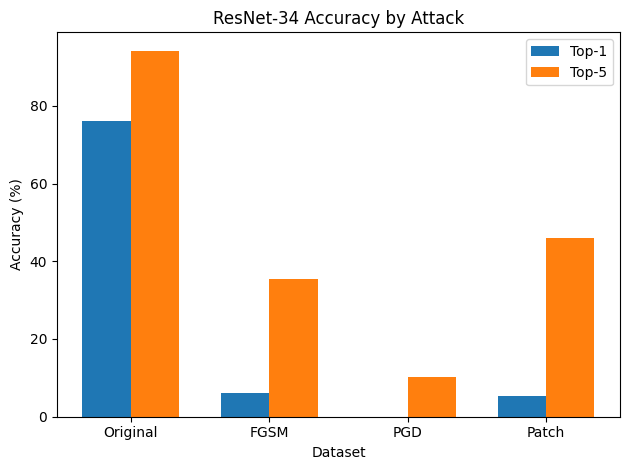

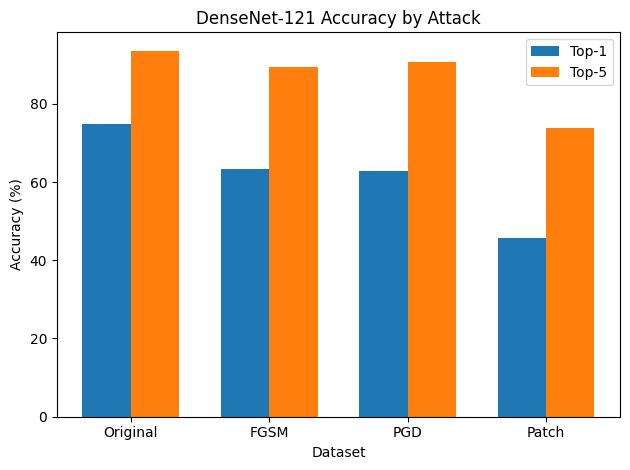

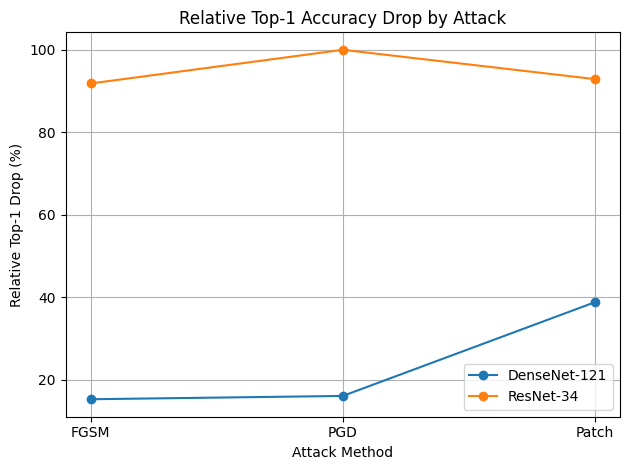

In [24]:
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 1) Collect accuracy numbers for both models and all datasets
models = {
    'ResNet-34': model,  # model from Task 1
    'DenseNet-121': torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device).eval()
}

datasets = {
    'Original': (None, None),
    'FGSM':     (adv1, lb1),
    'PGD':      (adv2, lb2),
    'Patch':    (adv3, lb3)
}

records = []
for mname, m in models.items():
    for tag, (adv, lbs) in datasets.items():
        if adv is None:
            loader = ldr
        else:
            ds_adv = TensorDataset(adv, torch.tensor(lbs))
            loader = DataLoader(ds_adv, batch_size=ldr.batch_size, shuffle=False)
        acc, _, _ = evaluate(m, loader)
        records.append({
            'Model': mname,
            'Dataset': tag,
            'Top-1': acc[1] * 100,
            'Top-5': acc[5] * 100
        })

df = pd.DataFrame(records)

# 2) Bar charts of Top-1 vs Top-5 for each model
for model_name in df['Model'].unique():
    sub = df[df['Model'] == model_name]
    x = range(len(sub))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar([i - width/2 for i in x], sub['Top-1'], width, label='Top-1')
    ax.bar([i + width/2 for i in x], sub['Top-5'], width, label='Top-5')

    ax.set_xticks(x)
    ax.set_xticklabels(sub['Dataset'])
    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Dataset')
    ax.set_title(f'{model_name} Accuracy by Attack')
    ax.legend()
    plt.tight_layout()
    plt.show()

# 3) Line plot of Relative Top-1 Drop
# Compute relative drop
df['Baseline'] = df.groupby('Model')['Top-1'].transform('first')
df['RelDrop'] = (df['Baseline'] - df['Top-1']) / df['Baseline'] * 100
line_df = df[df['Dataset'] != 'Original']

plt.figure()
for model_name, grp in line_df.groupby('Model'):
    plt.plot(grp['Dataset'], grp['RelDrop'], marker='o', label=model_name)

plt.title('Relative Top-1 Accuracy Drop by Attack')
plt.xlabel('Attack Method')
plt.ylabel('Relative Top-1 Drop (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Observations

|            Model | Dataset  | Top-1 (%) | Top-5 (%) |
| ---------------: | :------- | --------: | --------: |
|    **ResNet-34** | Original |     76.00 |     94.20 |
|    **ResNet-34** | FGSM     |      6.20 |     35.40 |
|    **ResNet-34** | PGD      |      0.00 |     10.00 |
|    **ResNet-34** | Patch    |      6.00 |     44.80 |
|                  |          |           |           |
| **DenseNet-121** | Original |     74.80 |     93.60 |
| **DenseNet-121** | FGSM     |     63.40 |     89.40 |
| **DenseNet-121** | PGD      |     63.20 |     91.00 |
| **DenseNet-121** | Patch    |     45.60 |     74.60 |




- **Baseline Robustness**  
  - ResNet-34 and DenseNet-121 achieve ~75% Top-1 and ~94% Top-5 on clean images.
- **Pixel-wise Attacks**  
  - FGSM (ε=0.02) collapses ResNet-34 to 6% Top-1 (≈92% relative drop); PGD drives it to 0%.  
  - On DenseNet-121, FGSM/PGD only reduce Top-1 to ~63% (≤16% relative drop), indicating weaker transfer.
- **Patch Attacks**  
  - A single 32×32 patch (ε=0.5) reduces ResNet-34 Top-1 to 6%, similar to FGSM.  
  - The same patch drops DenseNet-121 Top-1 to 45.6% (≈39% relative drop), showing stronger cross-model transfer.
- **Top-5 vs. Top-1**  
  - ResNet-34 Top-5 accuracy falls dramatically under all attacks (10–45%).  
  - DenseNet-121 maintains high Top-5 (≈90%) under FGSM/PGD, but drops more under patch attacks.

---

## Lessons & Mitigations

1. **Attack Diversity**  
   - Multi-step (PGD) is strongest on the source model but may overfit and transfer poorly.  
   - Simple FGSM is fast and transfers reasonably.  
   - Patch attacks generalize best across architectures.
2. **Defense Strategies**  
   - **Adversarial Training**: incorporate FGSM, PGD, and patch samples in the training loop.  
   - **Preprocessing**: apply input transformations (e.g. smoothing, compression) to remove small or localized perturbations.  
   - **Ensemble Methods**: combine predictions from multiple models to reduce single-model vulnerabilities.
3. **Evaluation Metrics**  
   - Always measure both Top-1 and Top-5, and report relative drops to understand severity across tasks.

---

## Conclusion

Our experiments demonstrate that even imperceptible pixel-level and small-patch perturbations can drastically degrade state-of-the-art image classifiers. While multi-step gradient attacks (PGD) can entirely break the source model, localized patch attacks often transfer more effectively to unseen architectures. Effective defenses will require a combination of adversarial training, robust preprocessing, and ensemble techniques to guard against both pixel-wise and patch-based adversaries.
